<font size=5> **[넷플릭스 데이터를 활용한 추천 시스템 개발]** </font>
- netflix_titles.csv 데이터를 활용하여 주요 데이터 시각화 및 추천 시스템을 개발하시오
- 각 마크다운 셀의 내용을 참고하여 비어있는 코드 셀에 코드를 작성합니다.
- 제시된 아웃풋은 참고이며 반드시 동일할 필요는 없습니다.
- <font color='red'><b>빨간색</b></font>으로 표기된 영역은 이미 작성되어 있는 코드로 그대로 활용하시면 됩니다.

# 데이터 로딩

In [209]:
import pandas as pd
import numpy as np

netflix_original = pd.read_csv('./netflix_titles.csv')

In [210]:
netflix = netflix_original.copy()
netflix.shape # (7787, 12)
netflix.columns # ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added','release_year', 'rating', 'duration', 'listed_in', 'description']

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

# 주요 데이터 시각화

## TV Show vs Movies (콘텐츠 타입) 막대 그래프
[예시]
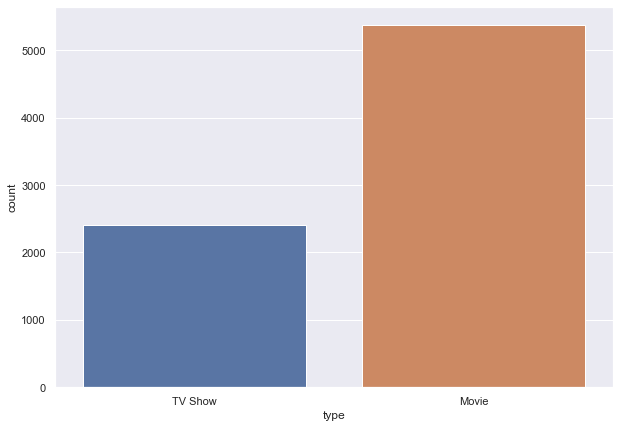

In [211]:
netflix['type'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7787 entries, 0 to 7786
Series name: type
Non-Null Count  Dtype 
--------------  ----- 
7787 non-null   object
dtypes: object(1)
memory usage: 61.0+ KB


In [212]:
netflix['type'].value_counts()

Movie      5377
TV Show    2410
Name: type, dtype: int64

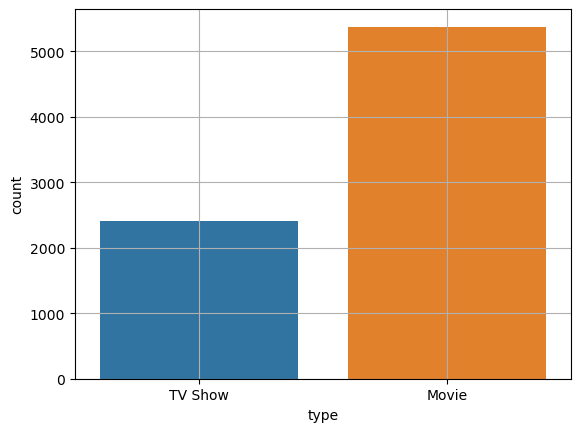

In [213]:
# 막대그래프 그리기
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=netflix, x='type')
plt.grid(True) # 격자
plt.show()

## 제작 국가별 수평 막대 그래프
- 결측 값 확인 및 결측 값을 포함한 레코드 삭제
- 2개 이상의 제작국가 값을 가지고 있는 레코드는 ‘,’를 기준으로 분류하여 카운팅 한다.
- 상위 10개국에 대한 막대그래프를 그린다.

### 국가 컬럼 내 결측 값 확인 및 결측 값을 포함한 레코드 삭제

In [214]:
netflix['country'].isna().sum() # 507개의 결측값

507

In [215]:
netflix.shape

(7787, 12)

In [216]:
netflix = netflix[netflix['country'].isna()==False]
netflix.shape

(7280, 12)

### 2개 이상의 제작국가 값을 가지고 있는 레코드는 ‘,’를 기준으로 분류하여 카운팅

In [217]:
new_list = []
for country in np.array(netflix['country']):
    country.split(',')
    new_list.append(country)
    
n = ','.join(new_list).replace(' ','').split(',')
df_ct = pd.DataFrame(np.array(n), columns=['국가명'])
df_ct.value_counts()[:10]

국가명          
UnitedStates     3297
India             990
UnitedKingdom     723
Canada            412
France            349
Japan             287
Spain             215
SouthKorea        212
Germany           199
Mexico            154
dtype: int64

In [218]:
top_n = pd.DataFrame(df_ct.value_counts()[:10], columns=['빈도수'])
top_n.reset_index('국가명', inplace=True)
top_n

,국가명,빈도수
0,UnitedStates,3297
1,India,990
2,UnitedKingdom,723
3,Canada,412
4,France,349
5,Japan,287
6,Spain,215
7,SouthKorea,212
8,Germany,199
9,Mexico,154


### 상위 10개국에 대한 막대그래프를 그린다.
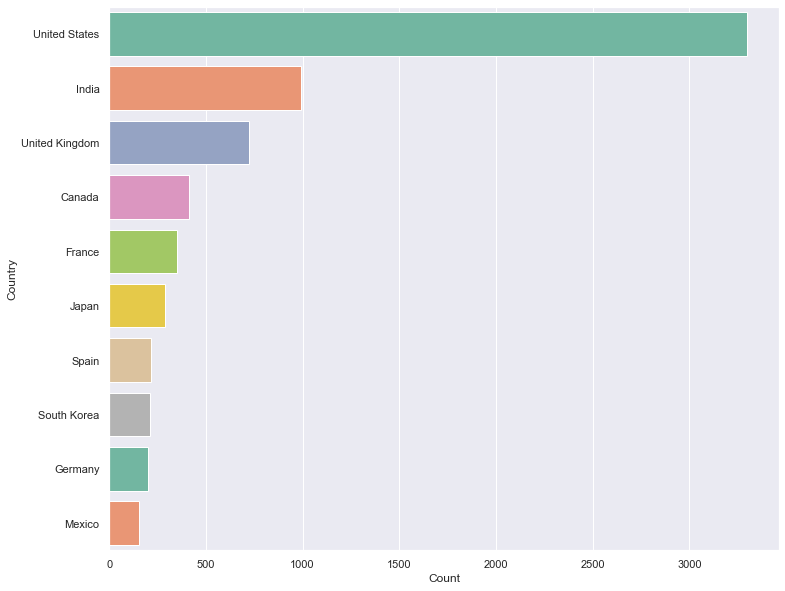

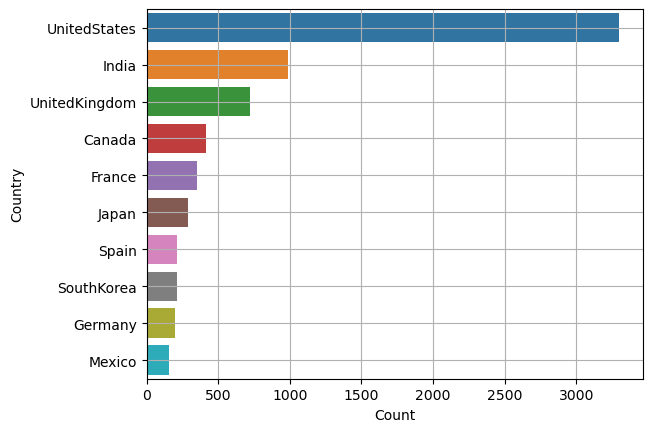

In [219]:
# 막대그래프 그리기
import matplotlib.pyplot as plt
import seaborn as sns

# sns.barplot() : plt.bar()과 유사
sns.barplot(data=top_n, x='빈도수', y='국가명')
plt.grid(True) # 격자
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

# 제목, 장르, 요약내용 특성 값을 기반으로 한 콘텐츠 기반 필터링 추천

## 데이터 전처리

### 추천 알고리즘 분석과 관련한 컬럼만 추출
- 추출 대상 컬럼: 'show_id', 'title', 'listed_in', 'description'    

- 처리결과
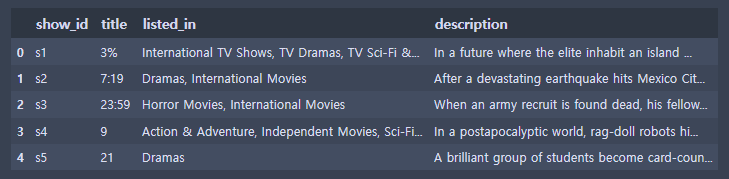

In [220]:
netflix.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [221]:
netflix_df = netflix[['show_id', 'title', 'listed_in', 'description']]
netflix_df.columns
netflix_df.head()

,show_id,title,listed_in,description
0,s1,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,7:19,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,23:59,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,9,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,21,Dramas,A brilliant group of students become card-coun...


### 형태소 분석 - 1
- title, listed_in, description 컬럼에 있는 텍스트 데이터의 모든 단어를 소문자로 변경
    - title 컬럼에 대한 형태소 분석 결과는 새로운 컬럼인 'title_list'로 생성
- nltk (Natural Language Tookit)의 word_tokenize 함수를 활용하여 단어를 공백문자를 기준으로 분할한다
- <font color='red'><b>[주의]</b></font>: 위 코드에서 분석에 필요한 컬럼만 추출해서 만든 DataFrame 객체의 변수 이름을 **netflix_df**로 한다.

In [222]:
# 파이썬 경고 메세지 출력 안하기
import warnings
warnings.filterwarnings(action='ignore')

import nltk
# 구두점: 글의 여러 가지 경계를 구분하기 위해 사용되는 반점(,), 온점(.), 물음표(?), 쌍점( : ), 쌍반점(;), 줄표(--), 붙임표(-) 등의 부호
# 불용어: 문장을 분석하는데 큰 의미가 없는 문자열
nltk.download('stopwords') # 구두점 사전 다운로드
nltk.download('punkt') # 불용어 사전 다운로드

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [223]:
# word_tokenize 함수: 문장을 공백 문자를 기준으로 분리한다
from nltk.tokenize import word_tokenize

# title, listed_in, description 컬럼 소문자 변경 및 분할 코드 작성

- 처리결과
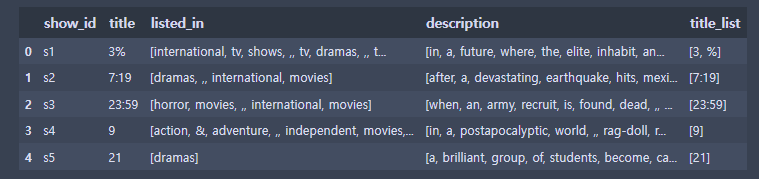

In [224]:
# title, listed_in, description 컬럼에 있는 텍스트 데이터의 모든 단어를 소문자로 변경
# title 컬럼에 대한 형태소 분석 결과는 새로운 컬럼인 'title_list'로 생성
# nltk (Natural Language Tookit)의 word_tokenize 함수를 활용하여 단어를 공백문자를 기준으로 분할한다

In [225]:
netflix_df['title'] = [title.lower() for title in netflix_df['title']]
netflix_df['listed_in'] = [title.lower() for title in netflix_df['listed_in']]
netflix_df['description'] = [title.lower() for title in netflix_df['description']]

In [226]:
netflix_df['title_list'] = netflix_df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
netflix_df['listed_in'] = netflix_df.apply(lambda row: nltk.word_tokenize(row['listed_in']), axis=1)
netflix_df['description'] = netflix_df.apply(lambda row: nltk.word_tokenize(row['description']), axis=1)
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"[international, tv, shows, ,, tv, dramas, ,, t...","[in, a, future, where, the, elite, inhabit, an...","[3, %]"
1,s2,7:19,"[dramas, ,, international, movies]","[after, a, devastating, earthquake, hits, mexi...",[7:19]
2,s3,23:59,"[horror, movies, ,, international, movies]","[when, an, army, recruit, is, found, dead, ,, ...",[23:59]
3,s4,9,"[action, &, adventure, ,, independent, movies,...","[in, a, postapocalyptic, world, ,, rag-doll, r...",[9]
4,s5,21,[dramas],"[a, brilliant, group, of, students, become, ca...",[21]


### 형태소 분석 - 2
- 단어별로 토큰 된 title_list, listed_in, description 컬럼 데이터 중 nltk 라이브러리의 stopwords 패키지를 활용하여 불용어(관사, 조사, 전치사 등 단어로서 의미가 없는 단어)를 제거한다.

In [227]:
from nltk.corpus import stopwords
from string import punctuation

# list_stopwords: 구두점 및 불용어 목록
list_stopwords = set(stopwords.words('english') + list(punctuation))
# list_stopwords
# title, listed_in, description 컬럼 데이터에서 구두점 및 불용어 단어를 제거 코드 작성

- 처리결과
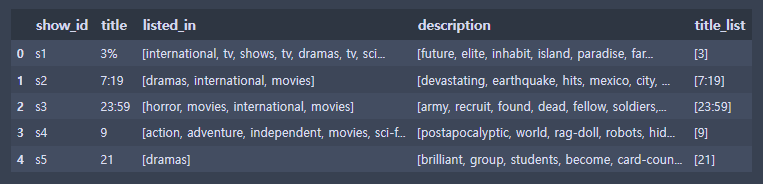

In [228]:
netflix_df['title_list'] = [ [ w for w in l if w not in list(list_stopwords)] for l in netflix_df['title_list'] ]
netflix_df['listed_in'] = [ [ w for w in l if w not in list(list_stopwords)] for l in netflix_df['listed_in'] ]
netflix_df['description'] = [ [ w for w in l if w not in list(list_stopwords)] for l in netflix_df['description'] ]
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"[international, tv, shows, tv, dramas, tv, sci...","[future, elite, inhabit, island, paradise, far...",[3]
1,s2,7:19,"[dramas, international, movies]","[devastating, earthquake, hits, mexico, city, ...",[7:19]
2,s3,23:59,"[horror, movies, international, movies]","[army, recruit, found, dead, fellow, soldiers,...",[23:59]
3,s4,9,"[action, adventure, independent, movies, sci-f...","[postapocalyptic, world, rag-doll, robots, hid...",[9]
4,s5,21,[dramas],"[brilliant, group, students, become, card-coun...",[21]


### <font color='red'> 형태소 분석 - 3 </font>
- description 컬럼 데이터에 포함된 구두점을 제거한다.
- 구두점: 글의 여러 가지 경계를 구분하기 위해 사용되는 반점(,), 온점(.), 물음표(?), 쌍점( : ), 쌍반점(;), 줄표(--), 붙임표(-) 등의 부호

In [229]:
import string

# 구두점 목록
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [230]:
import string

netflix_df['description'] = netflix_df['description'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
netflix_df['description'] 

0       [future, elite, inhabit, island, paradise, far...
1       [devastating, earthquake, hits, mexico, city, ...
2       [army, recruit, found, dead, fellow, soldiers,...
3       [postapocalyptic, world, ragdoll, robots, hide...
4       [brilliant, group, students, become, cardcount...
                              ...                        
7781    [dragged, civilian, life, former, superhero, m...
7782    [lebanon, s, civil, war, deprives, zozo, famil...
7783    [scrappy, poor, boy, worms, way, tycoon, s, dy...
7785    [dessert, wizard, adriano, zumbo, looks, next,...
7786    [documentary, delves, mystique, behind, bluesr...
Name: description, Length: 7280, dtype: object

### 형태소 분석 - 4
- title_list, listed_in, description 컬럼 데이터에 포함된 중복 단어를 제거한다. **(set() 함수 이용)**

In [231]:
netflix_df['title_list'] = [ set(l) for l in netflix_df['title_list'] ]
netflix_df['title_list']
netflix_df['listed_in'] = [ set(l) for l in netflix_df['listed_in'] ]
netflix_df['listed_in']
netflix_df['description'] = [ set(l) for l in netflix_df['description'] ]
netflix_df['description']
netflix_df.head()

,show_id,title,listed_in,description,title_list
0,s1,3%,"{tv, international, dramas, fantasy, sci-fi, s...","{chance, join, saved, elite, paradise, squalor...",{3}
1,s2,7:19,"{dramas, movies, international}","{life, hits, desperately, alive, trying, earth...",{7:19}
2,s3,23:59,"{movies, horror, international}","{soldiers, camp, fellow, found, forced, dead, ...",{23:59}
3,s4,9,"{action, movies, fantasy, sci-fi, independent,...","{newcomer, ragdoll, machines, exterminate, gro...",{9}
4,s5,21,{dramas},"{brilliant, millions, playing, intent, group, ...",{21}


# 콘텐츠 유사도 측정

## 피처 벡터화
- title_list, listed_in, description 컬럼의 각 단어를 공백문자로 구분되는 문자열로 변환하여 카운트 기반으로 피처 벡터화 한다.**(CountVectorizer 이용)**
- title_list, listed_in, description 각 컬럼의 피처 벡터화한 결과를 **matrix_netflix_vocab = []** 리스트에 저장한다.

In [232]:
netflix_df['title_list'] = netflix_df['title_list'].apply(lambda x : (' ').join(x))
netflix_df['listed_in'] = netflix_df['listed_in'].apply(lambda x : (' ').join(x))
netflix_df['description'] = netflix_df['description'].apply(lambda x : (' ').join(x))

In [233]:
netflix_df['listed_in'].head()

0         tv international dramas fantasy sci-fi shows
1                          dramas movies international
2                          movies horror international
3    action movies fantasy sci-fi independent adven...
4                                               dramas
Name: listed_in, dtype: object

In [234]:
matrix_netflix_vocab = []

In [235]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=0, ngram_range=(1,1))

country_mat1 = count_vect.fit_transform(netflix_df['title_list'])
count_vect.vocabulary_
print(country_mat1.shape) # (7280, 7735)
matrix_netflix_vocab.append(country_mat1)

(7280, 7735)


In [236]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=0, ngram_range=(1,1))

country_mat2 = count_vect.fit_transform(netflix_df['listed_in'])
count_vect.vocabulary_
print(country_mat2.shape) # (7280, 45)
matrix_netflix_vocab.append(country_mat2)

(7280, 45)


In [237]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=0, ngram_range=(1,1))

country_mat3 = count_vect.fit_transform(netflix_df['description'])
count_vect.vocabulary_
print(country_mat3.shape) # (7280, 18545)
matrix_netflix_vocab.append(country_mat3)

(7280, 18545)


In [238]:
len(matrix_netflix_vocab)

3

## 코사인 유사도
- title_list, listed_in, description 각 컬럼에 대해 피처 백터화 한 값을 이용하여 각각의 코사인 유사도를 산출하여 **matrix_netflix_sim = []** 리스트에 저장한다.

In [239]:
from sklearn.metrics.pairwise import cosine_similarity
matrix_netflix_sim = []

for i in range(len(matrix_netflix_vocab)):
    matrix_netflix_sim.append(cosine_similarity(matrix_netflix_vocab[i], matrix_netflix_vocab[i]))
    
len(matrix_netflix_sim)

3

- title_list, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스를 **netflix_sim_sorted_ind = []** 리스트에 저장한다.

In [240]:
netflix_sim_sorted_ind = []

for i in range(len(matrix_netflix_sim)):
    netflix_sim_sorted_ind.append(matrix_netflix_sim[i].argsort()[:,::-1])
    
len(netflix_sim_sorted_ind)    

3

# 유사도 필터링을 이용한 넷플릭스 콘텐츠 추천

- 추천 기준이 되는 콘텐츠의 제목으로 해당 콘텐츠 레코드를 추출한다.
- 추출된 콘텐츠의 인덱스 (netflix_df 데이터 프레임에서의 레코드 위치)를 추출한다.
- 해당 인덱스로 sorted_ind_list 인자로 입력된 netflix_sim_sorted_ind 객체에서 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 후 리스트에 저장한다.
- find_sim_netflix 함수 매개변수
    - df: 넷플릭스 콘텐츠 정보 DataFrame
    - sorted_ind_list: title_list, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스 행렬을 저장한 리스트
    - title_name: 추천 기준이 되는 콘텐츠 제목 (해당 콘텐츠와 장르 유사도가 높은 콘텐츠를 추천)
    - top_n: 추천 콘텐츠 건수

In [241]:
# 완성된 함수가 아니며, 위 마크다운 셀의 내용을 참고하여 함수 안의 코드를 완성한다.

def find_sim_netflix(df, sorted_ind_list, title_name, top_n=10):
    # 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 행렬을 저장할 리스트
    similar_indexes_list = []
        
    for idx in range(len(sorted_ind_list)):
        target_movie = df[df['title']==title_name.lower()]
        title_index = target_movie.index.values # index의 value 가져오기
        similar_indexes = sorted_ind_list[idx][title_index, :(top_n)]
#         similar_indexes = similar_indexes.reshape(-1)
#         print(similar_indexes)
    # 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 행렬을 저장할 리스트
        similar_indexes_list.append(similar_indexes)
#     print(similar_indexes_list)
    
    # 데이터 프레임의 인덱스 값으로 사용하기 위해 1차원 데이터로 변환한다.
    return df.iloc[np.array(similar_indexes_list).flatten()]

In [242]:
# '응답하라 1988' 과 제목, 장르, 줄거리가 유사한 콘텐츠를 각각 10개씩 추천
similar_netflix = find_sim_netflix(netflix_df, netflix_sim_sorted_ind, 'Reply 1988',10)

In [243]:
# 출력결과는 총 30개로 '응답하라 1988'과 제목, 장르, 줄거리가 유사한 콘텐츠 각각 10개씩을 포함하고 있다. 
similar_netflix[['title']]

,title
5539,shanghai
5540,shanghai fortress
7786,zz top: that little ol' band from texas
2606,happy 300 days
2594,handsome: a netflix mystery movie
2596,hangman
2597,hank: five years from the brink
2598,hannah gadsby: douglas
2599,hannah gadsby: nanette
2600,hannibal
